In [1]:
import os
import glob
import sys
import dotenv

import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.ml_tools import TrainTestSplitTask

import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.stumpf import get_stumpf_log_ratio
from sdb_utils.acolite import (
    get_acolite_band_tif_paths,
    get_eopatch_for_acolite_band_tif
)

import lightgbm as lgb
from lightgbm import (
    early_stopping,
    log_evaluation,
)
from sklearn.metrics import mean_squared_error

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
sentinel_archives_root = os.path.abspath(os.path.join(data_root_path, 'sentinel_puerto_rico'))
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 5, 2, 15, 7, 19),
  'D:\\sdb_datasets\\sentinel_puerto_rico\\S2B_MSIL2A_20210502T150719_N9999_R082_T19QFA_20220425T153242.SAFE')]

In [3]:
bathy_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'puerto_rico_bathy_eop')
)
load_bathy_eop = LoadTask(bathy_eop_path)

output_label = 'puerto_rico_bathy_eop'

wf_nodes = linearly_connect_tasks(
    load_bathy_eop,
    OutputTask(output_label),
)
workflow = EOWorkflow(wf_nodes)

workflow_result = workflow.execute()
puerto_rico_bathy_eop = workflow_result.outputs[output_label]

height, width, _ = puerto_rico_bathy_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
l2a_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(l2a_products[0][1], target_shape=(height, width), bbox=puerto_rico_bathy_eop.bbox)

merge_patches_task = MergeEOPatchesTask()
merged_eop = merge_patches_task.execute(puerto_rico_bathy_eop, l2a_eopatch)

merged_eop

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 319, 544, 12), dtype=uint16)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(319, 544, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(319, 544, 1), dtype=uint8)
  }
  meta_info={
    mission: 'S2B'
  }
  bbox=BBox(((686070.726989808, 2007089.913413469), (691510.726989808, 2010279.913413469)), crs=CRS('32619'))
  timestamp=[datetime.datetime(2021, 5, 2, 15, 7, 19)]
)

In [4]:
bathy_pixels = np.sum(merged_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1)

all_band_index_complete = np.repeat(merged_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], repeats=12, axis=-1)
X_all = np.reshape(merged_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_index_complete == 1], (bathy_pixels, 12))

X_all.shape

(173536, 12)

In [5]:
model = lgb.Booster(model_file='../models/tuned_lgbm_bahamas.txt')
y_hat_all = model.predict(X_all, num_iteration=model.best_iteration)
estimated_bathy_tuned_lgbm = np.zeros(merged_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
estimated_bathy_tuned_lgbm[merged_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

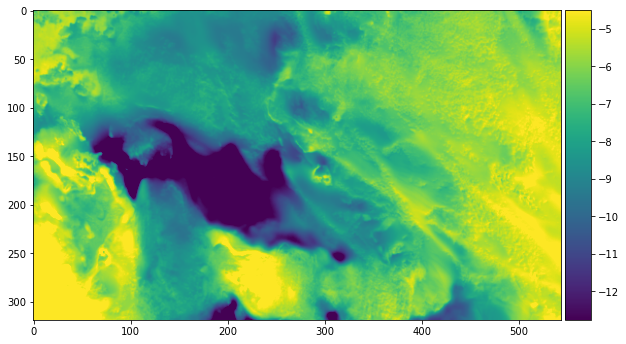

In [6]:
eolx.visualization.plot_single_band(merged_eop, (FeatureType.DATA_TIMELESS, 'bathy_data'), cmap='viridis')
plt.show()

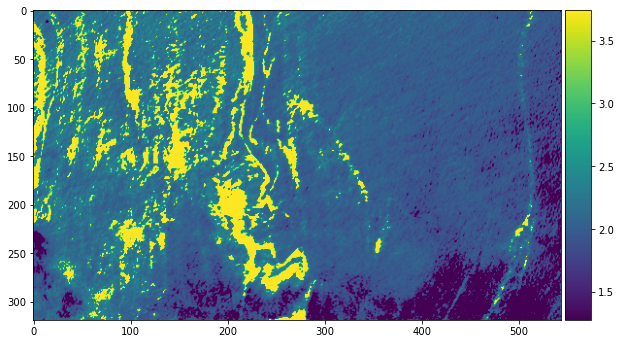

In [7]:
eolx.visualization.plot_ndarray_band(estimated_bathy_tuned_lgbm, cmap='viridis')
plt.show()

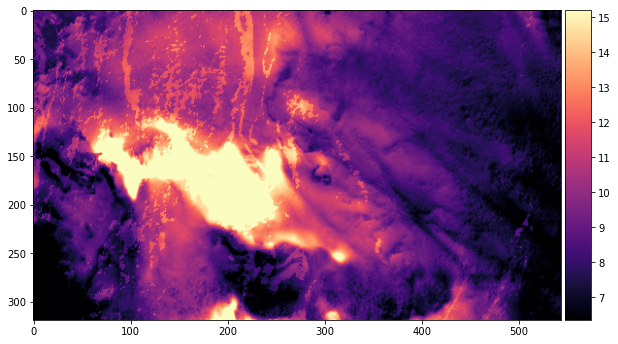

In [8]:
eolx.visualization.plot_ndarray_band(
    np.abs(estimated_bathy_tuned_lgbm - merged_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]),
    cmap='magma'
)
plt.show()